In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV

sns.set_theme()

from lab2 import Helper


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from sklearn.metrics import accuracy_score

In [2]:
df1 = pd.read_csv('Data/df1.csv')
df2 = pd.read_csv('Data/df2.csv')

display(df1.head(3), df2.head(3))

,id,age,cholesterol,gluc,smoke,alco,active,cardio,gender_2,bmi-feature_obese (class I),bmi-feature_obese (class II),bmi-feature_obese (class III),bmi-feature_overweight,bp-feature_healthy,bp-feature_hypertension crises,bp-feature_stage 1 hypertension,bp-feature_stage 2 hypertension
0,0,18393,1,1,0,0,1,0,1,0,0,0,0,0,0,1,0
1,1,20228,3,1,0,0,1,1,0,1,0,0,0,0,0,0,1
2,2,18857,3,1,0,0,0,1,0,0,0,0,0,0,0,1,0


,id,age,bmi,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,gender_2
0,0,18393,21,110,80,1,1,0,0,1,0,1
1,1,20228,34,140,90,3,1,0,0,1,1,0
2,2,18857,23,130,70,3,1,0,0,0,1,0


In [3]:
# Drop id as its not useful
df1 = df1.drop('id', axis=1)
df2 = df2.drop('id', axis=1)

### 2.4 - Välja modell

Chosen models:
* Logistic regression
* decision tree
* random forest

##### train|validation|test split

In [4]:
df1_x, df1_y = df1.drop('cardio', axis=1), df1['cardio']
df2_x, df2_y = df2.drop('cardio', axis=1), df2['cardio']

display(
    df1_x.head(1),
    df2_x.head(1)
)

,age,cholesterol,gluc,smoke,alco,active,gender_2,bmi-feature_obese (class I),bmi-feature_obese (class II),bmi-feature_obese (class III),bmi-feature_overweight,bp-feature_healthy,bp-feature_hypertension crises,bp-feature_stage 1 hypertension,bp-feature_stage 2 hypertension
0,18393,1,1,0,0,1,1,0,0,0,0,0,0,1,0


,age,bmi,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,gender_2
0,18393,21,110,80,1,1,0,0,1,1


In [5]:
df1_x_train, df1_x_val, df1_x_test, df1_y_train, df1_y_val, df1_y_test = Helper.train_val_test_split(df1_x, df1_y, split_size=0.2, rand_state=42)
df2_x_train, df2_x_val, df2_x_test, df2_y_train, df2_y_val, df2_y_test = Helper.train_val_test_split(df2_x, df2_y, split_size=0.2, rand_state=42)

display(
    (df1_x_train.shape, df1_y_train.shape, df1_x_val.shape, df1_y_val.shape, df1_x_test.shape, df1_y_test.shape),
    (df2_x_train.shape, df2_y_train.shape, df2_x_val.shape, df2_y_val.shape, df2_x_test.shape, df2_y_test.shape),
)

((40918, 15), (40918,), (13640, 15), (13640,), (13640, 15), (13640,))

((40918, 10), (40918,), (13640, 10), (13640,), (13640, 10), (13640,))

In [6]:
df1_x_train, df1_x_val = Helper.scaler('minmax', df1_x_train, df1_x_val)
df1_x_train.mean(), df1_x_train.std(), df1_x_val.mean(), df1_x_val.std()

(0.24469073517266024,
 0.4111901139656925,
 0.24653791612942894,
 0.4122246262036306)

In [7]:
"""
LogisticRegression
    Chosen parameters
        penalty: elasticnet
        solver: saga

    Hyperparamters
        max_iter [UNBOUNDED]
        l1_ratio [UNBOUNDED]
    
    
DecisionTreeClassifier
    Chosen parameters
        max_depth: None
        min_samples_split: 2
        min_samples_split: 1
        min_samples_leaf: 1
        min_weight_fraction_leaf: 0
        max_leaf_nodes: None
        min_impurity_decrease: 0
        class_weight: None

    Hyperparamters
        criterion [UNBOUNDED]
        splitter [UNBOUNDED]
        max_features [UNBOUNDED]
    

Grid Search parameters
    scoring
    cv [UNBOUNDED]
    
"""

'\nLogisticRegression\n    Chosen parameters\n        penalty: elasticnet\n        solver: saga\n\n    Hyperparamters\n        max_iter [UNBOUNDED]\n        l1_ratio [UNBOUNDED]\n    \n    \nDecisionTreeClassifier\n    Chosen parameters\n        max_depth: None\n        min_samples_split: 2\n        min_samples_split: 1\n        min_samples_leaf: 1\n        min_weight_fraction_leaf: 0\n        max_leaf_nodes: None\n        min_impurity_decrease: 0\n        class_weight: None\n\n    Hyperparamters\n        criterion [UNBOUNDED]\n        splitter [UNBOUNDED]\n        max_features [UNBOUNDED]\n    \n\nGrid Search parameters\n    scoring\n    cv [UNBOUNDED]\n    \n'

In [8]:
# All the data needed for chosing the right model and doing hyperparameter tuning via GridSearchCV

datasets = {
    'df1': {
        'x_train': df1_x_train,
        'x_val': df1_x_val,
        'x_test': df1_x_test,
        'y_train': df1_y_train,
        'y_val': df1_y_val,
        'y_test': df1_y_test
    },
    'df2': {
        'x_train': df2_x_train,
        'x_val': df2_x_val,
        'x_test': df2_x_test,
        'y_train': df2_y_train,
        'y_val': df2_y_val,
        'y_val': df2_y_test
     }
}


model_data = {
    'LogisticRegression': {
        'model': LogisticRegression(),
        'search space': {
            # Parameters
            'penalty': ['elasticnet'],
            'solver': ['saga'],
            
            # Hyperparamaters
            "max_iter" : [10, 100],
            "l1_ratio" : [0.1, 0.3]
        }
    },
    
    'DecisionTreeClassifier': {
        'model': DecisionTreeClassifier(),
        'search space': {
            # Hyperparamaters
            'criterion': ['gini', 'entropy', 'log_loss'],
            'splitter': ['best', 'random'],
            'max_features' : [None, 'sqrt', 'log2'],
        }
    },
    
    'RandomForestClassifier': {
        'model': RandomForestClassifier(),
        'search space': {
            # Parameters
            
            # Hyperparamaters
            'n_estimators': [1, 10],
            
            'criterion': ['gini', 'entropy', 'log_loss'],
            'max_features' : [None, 'sqrt', 'log2']
        }
    },
}

In [9]:
model_metrics = pd.DataFrame(columns=['Dataset', 'Scaling', 'Model', 'Hyper params', 'Accuracy'])
model_metrics

,Dataset,Scaling,Model,Hyper params,Accuracy


In [10]:
import warnings
warnings.filterwarnings('ignore')

model_metrics = pd.DataFrame(columns=['Dataset', 'Scaling', 'Model', 'Hyper params', 'Accuracy'])
model_metrics

for dataset_name, dataset in datasets.items():
    
    # Loop through and use the minmax and standard scaler
    for scaler_name in ['minmax', 'standard']:
        
        # Scale the data
        scaled_x_train, scaled_x_val = Helper.scaler(scaler_name, dataset['x_train'], dataset['x_val'])

        # loop through all models. data = dict with model object and parameter info
        for model_name, data in model_data.items():
            
            # Search # find the best hyperparamters
            GS = GridSearchCV(
                estimator = data['model'],
                param_grid = data['search space'],
                #n_jobs=2,
                scoring = 'accuracy',
                cv = 5,
                verbose = 3
            )
            
            GS.fit(scaled_x_train, dataset['y_train'])
            
            val_pred = GS.predict(scaled_x_val)
            
            score = accuracy_score(dataset['y_val'], val_pred)
            
            model_metrics.loc[len(model_metrics.index)] = [
                dataset_name,
                scaler_name,
                model_name,
                GS.best_params_,
                score
            ]
            

model_metrics

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END l1_ratio=0.1, max_iter=10, penalty=elasticnet, solver=saga;, score=0.696 total time=   0.2s
[CV 2/5] END l1_ratio=0.1, max_iter=10, penalty=elasticnet, solver=saga;, score=0.692 total time=   0.2s
[CV 3/5] END l1_ratio=0.1, max_iter=10, penalty=elasticnet, solver=saga;, score=0.692 total time=   0.1s
[CV 4/5] END l1_ratio=0.1, max_iter=10, penalty=elasticnet, solver=saga;, score=0.700 total time=   0.1s
[CV 5/5] END l1_ratio=0.1, max_iter=10, penalty=elasticnet, solver=saga;, score=0.710 total time=   0.1s
[CV 1/5] END l1_ratio=0.1, max_iter=100, penalty=elasticnet, solver=saga;, score=0.697 total time=   0.3s
[CV 2/5] END l1_ratio=0.1, max_iter=100, penalty=elasticnet, solver=saga;, score=0.693 total time=   0.3s
[CV 3/5] END l1_ratio=0.1, max_iter=100, penalty=elasticnet, solver=saga;, score=0.692 total time=   0.3s
[CV 4/5] END l1_ratio=0.1, max_iter=100, penalty=elasticnet, solver=saga;, score=0.700 total time

In [ ]:
# använda GridSearchCV() och välja lämplig evalueringsmetric (accurancy)
# gör prediction på valideringsdata
# beräkna och spara evaluation score för ditt valda metric
# checka bästa parametrarna för respektive modell

c:\Users\Kevin\.virtualenvs\Code-CYgrxAwh\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       0.42      0.11      0.18      6889
           1       0.48      0.85      0.61      6751

    accuracy                           0.47     13640
   macro avg       0.45      0.48      0.40     13640
weighted avg       0.45      0.47      0.39     13640



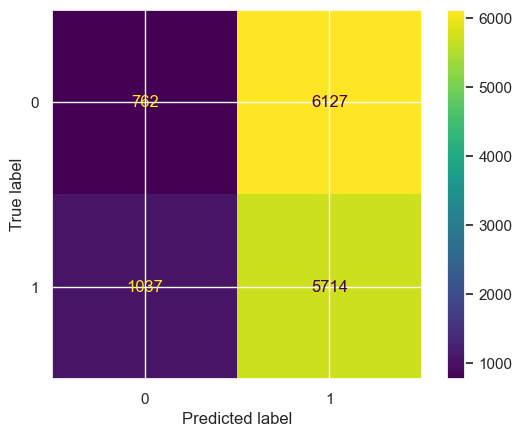

In [ ]:
clf = DecisionTreeClassifier()
clf.fit(df1_x_train, df1_y_train)
y_pred = clf.predict(df1_x_test)




# print(classification_report(df1_y_test, y_pred))
# cm = confusion_matrix(df1_y_test, y_pred)
# ConfusionMatrixDisplay(cm).plot();
